# Text-to-Speech (Recipe)

This is the example notebook of how-to-run the ESPnet TTS recipe using an4 dataset.  
You can understand the overview of TTS recipe through this notebook within an hour!

See also:
- Documentaion: [https://espnet.github.io/espnet](https://espnet.github.io/espnet)
- Github: [https://github.com/espnet](https://github.com/espnet)

Author: [Tomoki Hayashi](https://github.com/kan-bayashi)

Last update: 2019/07/25

## Setup envrionment

First, let's setup the environmet to run the recipe.  
It take around 10 minues. Please keep waiting for a while.


In [0]:
# OS setup
!sudo apt-get install bc tree
!cat /etc/os-release

# espnet setup
!git clone https://github.com/espnet/espnet
!cd espnet; pip install -e .

# warp ctc setup
!git clone https://github.com/espnet/warp-ctc -b pytorch-1.1
!cd warp-ctc && mkdir build && cd build && cmake .. && make -j
!cd warp-ctc/pytorch_binding && python setup.py install 

# kaldi setup
!cd /content/espnet/tools; git clone https://github.com/kaldi-asr/kaldi
!echo "" > ./espnet/tools/kaldi/tools/extras/check_dependencies.sh # ignore check
!chmod +x ./espnet/tools/kaldi/tools/extras/check_dependencies.sh
!cd ./espnet/tools/kaldi/tools; make sph2pipe sclite
!rm -rf espnet/tools/kaldi/tools/python
!wget https://18-198329952-gh.circle-artifacts.com/0/home/circleci/repo/ubuntu16-featbin.tar.gz
!tar -xf ./ubuntu16-featbin.tar.gz # take a few minutes
!cp featbin/* espnet/tools/kaldi/src/featbin/

# make dummy activate
!mkdir -p espnet/tools/venv/bin
!touch espnet/tools/venv/bin/activate

## Run the recipe

Now ready to run the recipe!   
We use the most simplest recipe `egs/an4/tts1` as an example.  
> Unfortunately, `egs/an4/tts1` is too small to generate reasonable speech.   
> But you can understand the flow or TTS recipe through this recipe since all of the TTS recipes has the exactly same flow.


In [0]:
# Let's go to an4 recipe!
import os
os.chdir("/content/espnet/egs/an4/tts1")

Before running the recipe, let us check the recipe structure.

In [3]:
!tree -L 1

.
├── cmd.sh
├── conf
├── data
├── downloads
├── dump
├── exp
├── fbank
├── local -> ../asr1/local
├── path.sh
├── run.sh
├── steps -> ../../../tools/kaldi/egs/wsj/s5/steps
├── tensorboard
└── utils -> ../../../tools/kaldi/egs/wsj/s5/utils

10 directories, 3 files


Each recipe has the same structure and files.  

- **run.sh**: Main script of the recipe. Once you run this script, all of the processing will be conducted from data download, preparation, feature extraction, training, and decoding.
- **cmd.sh**: Command configuration source file about how-to-run each processing. You can modify this script if you want to run the script through job control system e.g. Slurm or Torque.
- **path.sh**: Path configuration source file. Basically, we do not have to touch.
- **conf/**: Directory containing configuration files.
- **local/**: Directory containing the recipe-specific scripts e.g. data preparation.
- **steps/** and **utils/**: Directory containing kaldi tools.

Main script **run.sh** consists of several stages:

- **stage -1**: Download data if the data is available online.
- **stage 0**: Prepare data to make kaldi-stype data directory.
- **stage 1**: Extract feature vector, calculate statistics, and perform normalization.
- **stage 2**: Prepare a dictionary and make json files for training.
- **stage 3**: Train the E2E-TTS network.
- **stage 4**: Decode mel-spectrogram using the trained network.
- **stage 5**: Generate a waveform from a generated mel-spectrogram using Griffin-Lim.

Currently, we support the following networks:
- Tacotron2: [Natural TTS Synthesis by Conditioning WaveNet on Mel Spectrogram Predictions](https://arxiv.org/abs/1712.05884)
- Transformer: [Neural Speech Synthesis with Transformer Network](https://arxiv.org/pdf/1809.08895.pdf)
- FastSpeech: [FastSpeech: Fast, Robust and Controllable Text to Speech](https://arxiv.org/pdf/1905.09263.pdf)

Let us check each stage step-by-step via **--stage** and **--stop_stage** options!


### Stage -1: Data download

This stage downloads dataset if the dataset is available online.

In [4]:
!./run.sh --stage -1 --stop_stage -1

stage -1: Data Download
local/download_and_untar.sh: an4 directory already exists in ./downloads
dictionary: data/lang_1char/train_nodev_units.txt


In [5]:
!tree -L 1
!ls downloads/

.
├── cmd.sh
├── conf
├── data
├── downloads
├── dump
├── exp
├── fbank
├── local -> ../asr1/local
├── path.sh
├── run.sh
├── steps -> ../../../tools/kaldi/egs/wsj/s5/steps
├── tensorboard
└── utils -> ../../../tools/kaldi/egs/wsj/s5/utils

10 directories, 3 files
an4  an4_sphere.tar.gz


You can see **downloads** directory is cretead, which containing donwloaded an4 dataset.

### Stage 0: Data preparation

This stage creates kaldi-style data directories.

In [6]:
!./run.sh --stage 0 --stop_stage 0

stage 0: Data preparation
dictionary: data/lang_1char/train_nodev_units.txt


In [7]:
!tree -L 1 data

data
├── lang_1char
├── test
├── train
├── train_dev
└── train_nodev

5 directories, 0 files


Through the data preparation stage, kaldi-style data directories will be created.  
Here, **data/train/** is corresponding to training set,  and **data/test** is corresponding to evaluation set.  
Each directory has the same following files:

In [8]:
!ls data/*

data/lang_1char:
train_nodev_units.txt

data/test:
feats.scp  filetype  spk2utt  text  utt2num_frames  utt2spk  wav.scp

data/train:
feats.scp  filetype  spk2utt  text  utt2num_frames  utt2spk  wav.scp

data/train_dev:
feats.scp  spk2utt  text  utt2num_frames  utt2spk  wav.scp

data/train_nodev:
cmvn.ark  feats.scp  spk2utt  text  utt2num_frames  utt2spk  wav.scp


The above four files are all we have to prepare to create new recipes.  
Let's check each file.

In [9]:
!head -n 3 data/train/{wav.scp,text,utt2spk,spk2utt}

==> data/train/wav.scp <==
fash-an251-b /content/espnet/egs/an4/tts1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an251-fash-b.sph |
fash-an253-b /content/espnet/egs/an4/tts1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an253-fash-b.sph |
fash-an254-b /content/espnet/egs/an4/tts1/../../../tools/kaldi/tools/sph2pipe_v2.5/sph2pipe -f wav -p -c 1 ./downloads/an4/wav/an4_clstk/fash/an254-fash-b.sph |

==> data/train/text <==
fash-an251-b YES
fash-an253-b GO
fash-an254-b YES

==> data/train/utt2spk <==
fash-an251-b fash
fash-an253-b fash
fash-an254-b fash

==> data/train/spk2utt <==
fash fash-an251-b fash-an253-b fash-an254-b fash-an255-b fash-cen1-b fash-cen2-b fash-cen4-b fash-cen5-b fash-cen7-b
fbbh fbbh-an86-b fbbh-an87-b fbbh-an88-b fbbh-an89-b fbbh-an90-b fbbh-cen1-b fbbh-cen2-b fbbh-cen3-b fbbh-cen4-b fbbh-cen5-b fbbh-cen6-b fbbh-cen7-b fbbh-cen8-b
fclc fclc-an146-b fclc-an14

Each file contains the following information:
- **wav.scp**: List of audio path. Each line has `<utt_id> <wavfile_path or command pipe>`. `<utt_id>` must be unique.
- **text**: List of transcriptions. Each line has `<utt_id> <transcription>`. In the case of TTS, we assume that `<transcription>` is cleaned.
- **utt2spk**: List of correspondence table between utterances and speakers. Each line has `<utt_id> <speaker_id>`.
- **spk2utt**: List of correspondence table between speakers and utterances. Each lien has `<speaker_id> <utt_id> ... <utt_id> `. This file can be automatically created from **utt2spk**. 

In the ESPnet, speaker information is not used for any processing.   
Therefore, **utt2spk** and **spk2utt** can be a dummy.

### Stage 1: Feature extration

This stage performs the following processing:
1. Mel-spectrogram extraction
2. Data split into training and validation set
2. Statistics (mean and variance) calculation
3. Normalization

In [10]:
!./run.sh --stage 1 --stop_stage 1 --nj 4

stage 1: Feature Generation
/content/espnet/egs/an4/tts1/../../../utils/make_fbank.sh --cmd run.pl --nj 4 --fs 16000 --fmax  --fmin  --n_fft 1024 --n_shift 256 --win_length  --n_mels 80 data/train exp/make_fbank/train fbank
/content/espnet/egs/an4/tts1/../../../utils/make_fbank.sh: moving data/train/feats.scp to data/train/.backup
utils/validate_data_dir.sh: Successfully validated data-directory data/train
/content/espnet/egs/an4/tts1/../../../utils/make_fbank.sh: [info]: no segments file exists: assuming pcm.scp indexed by utterance.
Succeeded creating filterbank features for train
/content/espnet/egs/an4/tts1/../../../utils/make_fbank.sh --cmd run.pl --nj 4 --fs 16000 --fmax  --fmin  --n_fft 1024 --n_shift 256 --win_length  --n_mels 80 data/test exp/make_fbank/test fbank
/content/espnet/egs/an4/tts1/../../../utils/make_fbank.sh: moving data/test/feats.scp to data/test/.backup
utils/validate_data_dir.sh: Successfully validated data-directory data/test
/content/espnet/egs/an4/tts1/../.

Raw filterbanks are saved in **fbank/** directory with ark/scp format.

In [11]:
!ls fbank

raw_fbank_test.1.ark  raw_fbank_test.4.ark   raw_fbank_train.3.ark
raw_fbank_test.1.scp  raw_fbank_test.4.scp   raw_fbank_train.3.scp
raw_fbank_test.2.ark  raw_fbank_train.1.ark  raw_fbank_train.4.ark
raw_fbank_test.2.scp  raw_fbank_train.1.scp  raw_fbank_train.4.scp
raw_fbank_test.3.ark  raw_fbank_train.2.ark
raw_fbank_test.3.scp  raw_fbank_train.2.scp


**.ark** is binary file and **.scp** contain the correspondence between `<utt_id>` and `<path_in_ark>`.  
Since feature extraction can be performed for split small sets in parallel, raw_fbank is split into `raw_fbank_*.{1..N}.{scp,ark}.`

In [12]:
!head -n 3 fbank/raw_fbank_train.1.scp

fash-an251-b /content/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:13
fash-an253-b /content/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:5727
fash-an254-b /content/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:9921


These files can be loaded in python via **kaldiio** as follows:

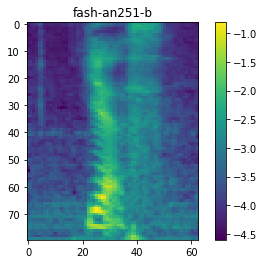

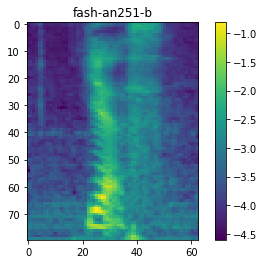

In [13]:
import kaldiio
import matplotlib.pyplot as plt

# load scp file
scp_dict = kaldiio.load_scp("fbank/raw_fbank_train.1.scp")
for key in scp_dict:
    plt.imshow(scp_dict[key].T[::-1])
    plt.title(key)
    plt.colorbar()
    plt.show()
    break
    
# load ark file
ark_generator = kaldiio.load_ark("fbank/raw_fbank_train.1.ark")
for key, array in ark_generator:
    plt.imshow(array.T[::-1])
    plt.title(key)
    plt.colorbar()
    plt.show()
    break

After raw mel-spectrogram extraction, some files are added in **data/train/**.  
**feats.scp** is concatenated scp file of **fbank/raw_fbank_train.{1..N}.scp**.  
**utt2num_frames** has the number of feature frames of each `<utt_id>`.

In [14]:
!ls data/train
!head -n 3 data/train/{feats.scp,utt2num_frames}

feats.scp  filetype  spk2utt  text  utt2num_frames  utt2spk  wav.scp
==> data/train/feats.scp <==
fash-an251-b /content/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:13
fash-an253-b /content/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:5727
fash-an254-b /content/espnet/egs/an4/tts1/fbank/raw_fbank_train.1.ark:9921

==> data/train/utt2num_frames <==
fash-an251-b 63
fash-an253-b 44
fash-an254-b 57


And **data/train/** directory is split into two directory:
- **data/train_nodev/**: data directory for training
- **data/train_dev/**: data directory for validation


In [15]:
!ls data
!ls data/train_*

lang_1char  test  train  train_dev  train_nodev
data/train_dev:
feats.scp  spk2utt  text  utt2num_frames  utt2spk  wav.scp

data/train_nodev:
cmvn.ark  feats.scp  spk2utt  text  utt2num_frames  utt2spk  wav.scp


You can find **cmvn.ark** in **data/train_nodev**, which is the calculated statistics file.  
This file also can be loaded in python via kaldiio.


In [16]:
# load cmvn.ark file (Be careful not load_ark, but load_mat)
cmvn = kaldiio.load_mat("data/train_nodev/cmvn.ark")

# cmvn consists of mean and variance, the last dimension of mean represents the number of frames.
print("cmvn shape = "+ str(cmvn.shape))

# calculate mean and variance
mu = cmvn[0, :-1] / cmvn[0, -1]
var = cmvn[1, :-1] / cmvn[0, -1]

# show mean
print("mean = " + str(mu))
print("variance = " + str(var))

cmvn shape = (2, 81)
mean = [-2.3015275 -2.1957324 -1.9654763 -1.9376634 -1.7633141 -1.6846672
 -1.7875645 -1.9486219 -1.9248276 -1.8872185 -1.9270604 -1.991474
 -1.9778731 -2.09246   -2.1971824 -2.209918  -2.3019788 -2.2964242
 -2.32575   -2.3705876 -2.40271   -2.449803  -2.4300003 -2.466036
 -2.5255735 -2.5386114 -2.582323  -2.5250685 -2.6118424 -2.632455
 -2.6633208 -2.672028  -2.6356308 -2.6361263 -2.6829064 -2.691491
 -2.694131  -2.675015  -2.6734142 -2.665589  -2.6630545 -2.6658235
 -2.657909  -2.6691167 -2.6635575 -2.6643658 -2.6674545 -2.661883
 -2.6606252 -2.657067  -2.6489155 -2.6527998 -2.6650834 -2.678152
 -2.698867  -2.708589  -2.7201533 -2.7215238 -2.7254083 -2.7388637
 -2.7713299 -2.8122768 -2.8621979 -2.9113584 -2.9572158 -3.0068166
 -3.0537205 -3.1046875 -3.160605  -3.2164888 -3.2550604 -3.2886407
 -3.3207698 -3.3445303 -3.3530545 -3.3561647 -3.357716  -3.3631625
 -3.3077478 -3.2325494]
variance = [ 5.478512   5.1941466  4.6532855  4.389601   3.6336286  3.4551063
  3.7

Normalzed features for training, validation and evaluation set are dumped in **dump/{train_nodev,train_dev,test}/**.  
There ark and scp can be loaded as the same as the above procedure.



In [17]:
!ls dump/*

dump/test:
data.json    feats.2.ark  feats.3.scp  feats.scp  utt2num_frames
feats.1.ark  feats.2.scp  feats.4.ark  filetype
feats.1.scp  feats.3.ark  feats.4.scp  log

dump/train_dev:
data.json    feats.2.ark  feats.3.scp  feats.scp  utt2num_frames
feats.1.ark  feats.2.scp  feats.4.ark  filetype
feats.1.scp  feats.3.ark  feats.4.scp  log

dump/train_nodev:
data.json    feats.2.ark  feats.3.scp  feats.scp  utt2num_frames
feats.1.ark  feats.2.scp  feats.4.ark  filetype
feats.1.scp  feats.3.ark  feats.4.scp  log


### Stage 2: Dictionary and json preparation

This stage creates dictrionary from **data/train_nodev/text** and makes json file for training.

In [18]:
!./run.sh --stage 2 --stop_stage 2

dictionary: data/lang_1char/train_nodev_units.txt
stage 2: Dictionary and Json Data Preparation
28 data/lang_1char/train_nodev_units.txt
/content/espnet/egs/an4/tts1/../../../utils/data2json.sh --feat dump/train_nodev/feats.scp data/train_nodev data/lang_1char/train_nodev_units.txt
/content/espnet/egs/an4/tts1/../../../utils/feat_to_shape.sh --cmd run.pl --nj 1 --filetype  --preprocess-conf  --verbose 0 dump/train_nodev/feats.scp data/train_nodev/tmp-6VLm9/input/shape.scp
/content/espnet/egs/an4/tts1/../../../utils/data2json.sh --feat dump/train_dev/feats.scp data/train_dev data/lang_1char/train_nodev_units.txt
/content/espnet/egs/an4/tts1/../../../utils/feat_to_shape.sh --cmd run.pl --nj 1 --filetype  --preprocess-conf  --verbose 0 dump/train_dev/feats.scp data/train_dev/tmp-g5AHB/input/shape.scp
/content/espnet/egs/an4/tts1/../../../utils/data2json.sh --feat dump/test/feats.scp data/test data/lang_1char/train_nodev_units.txt
/content/espnet/egs/an4/tts1/../../../utils/feat_to_shape.s

Dictrionary file will be created in **data/lang_1char/**.  
Dictionary file consists of `<token>` `<token index>`.  
Here, `<token index>` starts from 1 because 0 is used as padding index.


In [19]:
!ls data
!cat data/lang_1char/train_nodev_units.txt

lang_1char  test  train  train_dev  train_nodev
<unk> 1
<space> 2
A 3
B 4
C 5
D 6
E 7
F 8
G 9
H 10
I 11
J 12
K 13
L 14
M 15
N 16
O 17
P 18
Q 19
R 20
S 21
T 22
U 23
V 24
W 25
X 26
Y 27
Z 28


Json file will be created for training / validation /evaludation sets and they are saved as **dump/{train_nodev,train_dev,test}/data.json**.

In [20]:
!ls dump/*/*.json

dump/test/data.json  dump/train_dev/data.json  dump/train_nodev/data.json


Each json file contains all of the information in the data directory.

In [21]:
!head -n 27 dump/train_nodev/data.json

{
    "utts": {
        "fash-an251-b": {
            "input": [
                {
                    "feat": "/content/espnet/egs/an4/tts1/dump/train_nodev/feats.1.ark:13",
                    "name": "input1",
                    "shape": [
                        63,
                        80
                    ]
                }
            ],
            "output": [
                {
                    "name": "target1",
                    "shape": [
                        3,
                        30
                    ],
                    "text": "YES",
                    "token": "Y E S",
                    "tokenid": "27 7 21"
                }
            ],
            "utt2spk": "fash"
        },


- "shape": Shape of the input or output sequence. Here input shape [63, 80] represents the number of frames = 63 and the dimension of mel-spectrogram = 80.
- "text": Original transcription.
- "token": Token sequence of original transcription.
- "tokenid" Token id sequence of original transcription, which is converted using the dictionary.

Now ready to start training!

### Stage 3: Network training

This stage performs training of the network.  
Network training configurations are written as **.yaml** format file.  
Let us check the default cofiguration **conf/train_pytroch_tacotron2.yaml**.

In [22]:
!cat conf/train_pytorch_tacotron2.yaml

# This is the basic tactron2 training settting

# encoder related
embed-dim: 512
elayers: 1
eunits: 512
econv-layers: 3 # if set 0, no conv layer is used
econv-chans: 512
econv-filts: 5

# decoder related
dlayers: 2
dunits: 1024
prenet-layers: 2  # if set 0, no prenet is used
prenet-units: 256
postnet-layers: 5 # if set 0, no postnet is used
postnet-chans: 512
postnet-filts: 5

# attention related
atype: location
adim: 128
aconv-chans: 32
aconv-filts: 15      # resulting in filter-size = aconv-filts * 2 + 1
cumulate-att-w: true # whether to cumulate attetion weight
use-batch-norm: true # whether to use batch normalization in conv layer
use-concate: true    # whether to concatenate encoder embedding with decoder lstm outputs
use-residual: false  # whether to use residual connection in encoder convolution
use-masking: true    # whether to mask the padded part in loss calculation
bce-pos-weight: 1.0  # weight for positive samples of stop token in cross-entropy calculation
reduction-factor

You can modify this configuration file to change the hyperparameters.  
Here, let's change the number of epochs for this demonstration.

In [23]:
# TODO(kan-bayashi): Change here to use change_yaml.py
!cat conf/train_pytorch_tacotron2.yaml | sed -e "s/epochs: 50/epochs: 3/g" > conf/train_pytorch_tacotron2_sample.yaml
!cat conf/train_pytorch_tacotron2_sample.yaml

# This is the basic tactron2 training settting

# encoder related
embed-dim: 512
elayers: 1
eunits: 512
econv-layers: 3 # if set 0, no conv layer is used
econv-chans: 512
econv-filts: 5

# decoder related
dlayers: 2
dunits: 1024
prenet-layers: 2  # if set 0, no prenet is used
prenet-units: 256
postnet-layers: 5 # if set 0, no postnet is used
postnet-chans: 512
postnet-filts: 5

# attention related
atype: location
adim: 128
aconv-chans: 32
aconv-filts: 15      # resulting in filter-size = aconv-filts * 2 + 1
cumulate-att-w: true # whether to cumulate attetion weight
use-batch-norm: true # whether to use batch normalization in conv layer
use-concate: true    # whether to concatenate encoder embedding with decoder lstm outputs
use-residual: false  # whether to use residual connection in encoder convolution
use-masking: true    # whether to mask the padded part in loss calculation
bce-pos-weight: 1.0  # weight for positive samples of stop token in cross-entropy calculation
reduction-factor

Let's train the network.  
You can specify the config file via **--train_config** option.
It takes several minutes.


In [24]:
!./run.sh --stage 3 --stop_stage 3 --train_config conf/train_pytorch_tacotron2_sample.yaml --verbose 1

dictionary: data/lang_1char/train_nodev_units.txt
stage 3: Text-to-speech model training
^C


You can see the training log in `exp/train_*/train.log`.

The models are saved in `exp/train_*/results/` directory.

In [26]:
!ls exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/{results,results/att_ws}

exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results:
all_loss.png  l1_loss.png  model.loss.best  snapshot.ep.2
att_ws	      loss.png	   mse_loss.png     snapshot.ep.3
bce_loss.png  model.json   snapshot.ep.1

exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/att_ws:
fash-an251-b.ep.1.png  fash-an253-b.ep.3.png  fash-an255-b.ep.2.png
fash-an251-b.ep.2.png  fash-an254-b.ep.1.png  fash-an255-b.ep.3.png
fash-an251-b.ep.3.png  fash-an254-b.ep.2.png  fash-cen1-b.ep.1.png
fash-an253-b.ep.1.png  fash-an254-b.ep.3.png  fash-cen1-b.ep.2.png
fash-an253-b.ep.2.png  fash-an255-b.ep.1.png  fash-cen1-b.ep.3.png


`exp/train_*/results/*.png` are the figures of training curve.

all loss curve


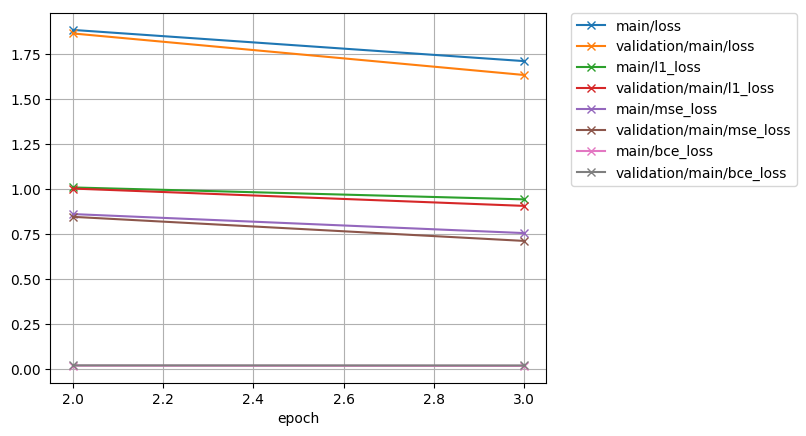

l1 loss curve


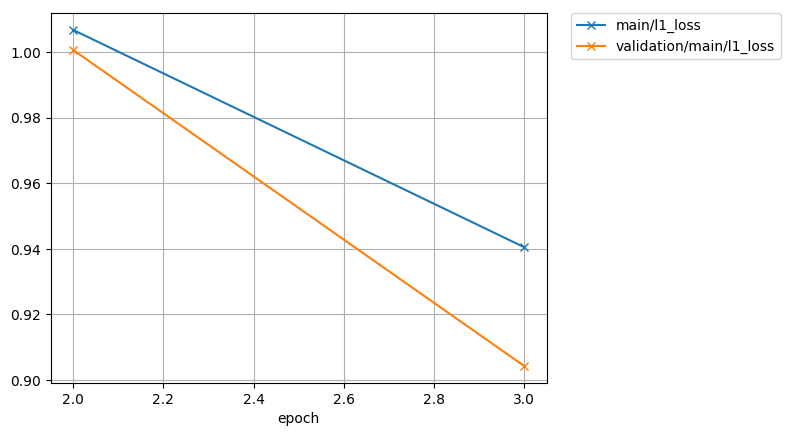

mse loss curve


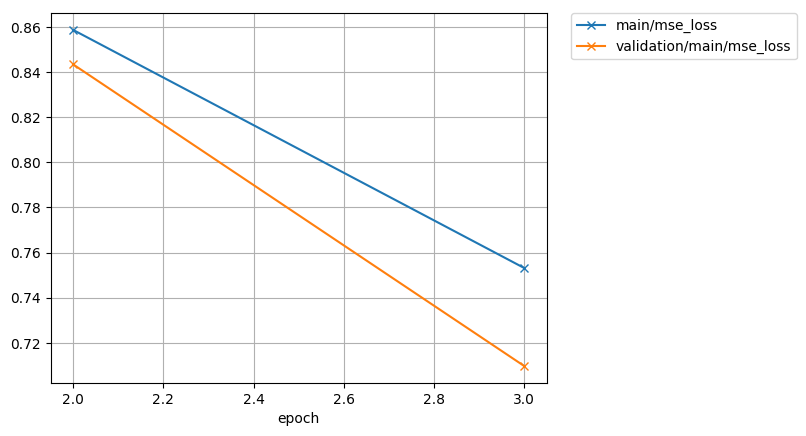

bce loss curve


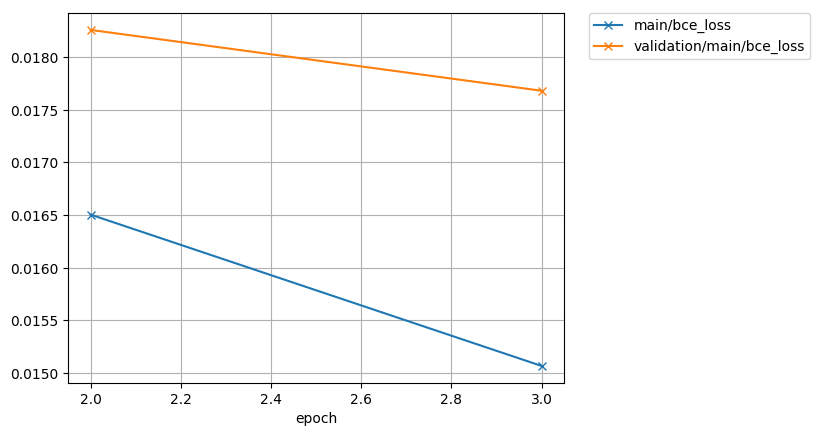

In [27]:
from IPython.display import Image, display_png
print("all loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/all_loss.png"))
print("l1 loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/l1_loss.png"))
print("mse loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/mse_loss.png"))
print("bce loss curve")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/bce_loss.png"))

`exp/train_*/results/att_ws/.png` are the figures of attention weights in each epoch.

Attention weights of initial epoch


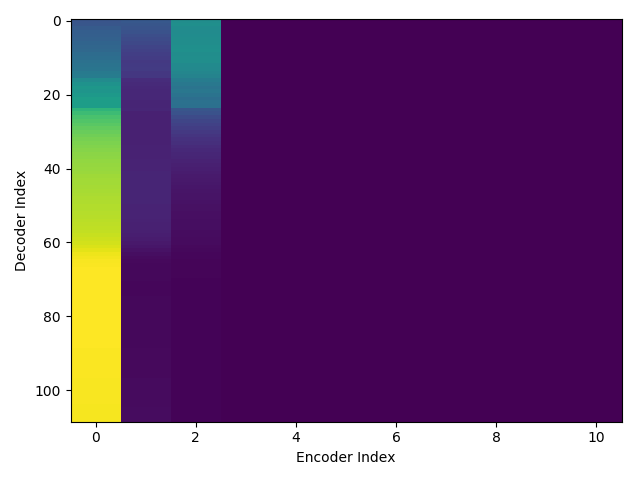

In [28]:
print("Attention weights of initial epoch")
display_png(Image("exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/att_ws/fash-cen1-b.ep.1.png"))

`exp/train_*/results/model.loss.best` contains only the model parameters.  
On the other hand, `exp/train_*/results/snapshot` contains the model parameters, optimizer states, and iterator states.  
So you can restart from the training by specifying the snapshot file with **--resume** option.


In [0]:
# resume training from snapshot.ep.2
!./run.sh --stage 3 --stop_stage 3 --train_config conf/train_pytorch_tacotron2_sample.yaml --resume exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/snapshot.ep.2 --verbose 1

dictionary: data/lang_1char/train_nodev_units.txt
stage 3: Text-to-speech model training


In [0]:
!cat exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/train.log

Also, we support tensorboard.  
You can see the training log through tensorboard.

In [0]:
%load_ext tensorboard
%tensorboard --logdir tensorboard/train_nodev_pytorch_train_pytorch_tacotron2_sample/

### Stage 4: Network decoding

This stage performs decoding using the trained model to generate mel-spectrogram from a given text.  


In [0]:
!./run.sh --stage 4 --stop_stage 4 --nj 8 --train_config conf/train_pytorch_tacotron2_sample.yaml 

Generated features are saved as ark/scp format.

In [0]:
!ls exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode/*

We can specify the model or snapshot to be used for decoding via **--model**.   

In [0]:
!./run.sh --stage 4 --stop_stage 4 --nj 8 --train_config conf/train_pytorch_tacotron2_sample.yaml --model snapshot.ep.2

In [0]:
!ls exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_snapshot.ep.2_decode/*

### Stage 5: Waveform synthesis

Finally, in this stage, we generate waveform using Grrifin-Lim algorithm.  
First, we perform de-normalization to convert the generated mel-spectrogram into the original scale.  
Then we apply Grrifin-Lim algorithm to restore phase components and apply inverse STFT to generate waveforms.

In [0]:
!./run.sh --stage 5 --stop_stage 5 --nj 8 --train_config conf/train_pytorch_tacotron2_sample.yaml --griffin_lim_iters 50

Generated wav files are saved in `exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode_denorm/*/wav`

In [0]:
!ls exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/outputs_model.loss.best_decode_denorm/*/wav

In [0]:
!tree -L 3

## NEXT step

- Try pretrained model to generate speech.
- Try a large single speaker dataset recipe **egs/ljspeech/tts1**.
- Try a large multi-speaker recipe **egs/libritts/tts1**.
- Make the original recipe using your own dataset.